In [185]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize, Bounds, OptimizeResult
from scipy.optimize import Bounds
from scipy.optimize import differential_evolution

In [186]:
from scipy.stats import norm, nbinom
class ECIRModel:
    """Extended Cox-Ingersoll-Ross (CIR) model with Negative Binomial jumps for interest rate dynamics."""
    
    def __init__(self, kappa: float, mu_r: float, sigma: float, p: float, r: int, mu: float, gamma: float):
        """
        Initializes the extended CIR model with parameters.
        :param kappa: Mean reversion speed.
        :param mu_r: Long-term mean interest rate.
        :param sigma: Volatility of the interest rate.
        :param p: Probability of success in each Bernoulli trial for the Negative Binomial distribution.
        :param r: Number of successes until the process is stopped (Negative Binomial parameter).
        :param mu: Mean of the normal distribution for jump sizes.
        :param gamma: Standard deviation of the normal distribution for jump sizes.
        """
        self.kappa = kappa
        self.mu_r = mu_r
        self.sigma = sigma
        self.p = p
        self.r = r
        self.mu = mu
        self.gamma = gamma

    def next_rate(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method.
        :param current_rate: Current interest rate.
        :param dt: Time increment.
        :return: Next interest rate.
        """
        normal_shock = np.random.normal(0, 1)
        drift = self.kappa * (self.mu_r - current_rate) * dt
        diffusion = self.sigma * np.sqrt(max(current_rate, 0)) * np.sqrt(dt) * normal_shock
        new_rate = current_rate + drift + diffusion
        return max(new_rate, 0)  # Ensure non-negativity

    def next_rate_with_jumps(self, current_rate: float, dt: float) -> float:
        """
        Simulates the next interest rate using the Euler-Maruyama method with Negative Binomial jumps.
        :param current_rate: Current interest rate.
        :param dt: Time increment.
        :return: Next interest rate including jumps.
        """
        # Standard CIR process simulation
        new_rate = self.next_rate(current_rate, dt)
        
        # Check for the occurrence of a jump
        num_jumps = np.random.negative_binomial(self.r, self.p)
        if num_jumps > 0:
            jump_sizes = np.random.normal(self.mu, self.gamma, num_jumps)
            total_jump = np.sum(jump_sizes)
            new_rate += total_jump
        
        return max(new_rate, 0)  # Ensure non-negativity

    def exact_solution(self, initial_rate: float, maturity: float) -> float:
        """
        Calculates the exact bond price under the CIR model for a zero-coupon bond.
        :param initial_rate: Initial interest rate.
        :param maturity: Time to maturity of the bond.
        :return: Bond price.
        """
        gamma = np.sqrt(self.kappa**2 + 2*self.sigma**2)
        B = (2 * (np.exp(gamma * maturity) - 1)) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma)
        A = ((2 * self.kappa * self.mu_r) / self.sigma**2) * np.log(
            2 * gamma * np.exp((gamma + self.kappa) * maturity / 2) / ((gamma + self.kappa) * (np.exp(gamma * maturity) - 1) + 2 * gamma))
        return np.exp(A - B * initial_rate)

    def transition_density(self, rt: float, rt_1: float, dt: float, terms_limit: int = 2) -> float:
        density_sum = 0
        for n in range(terms_limit):
            rate_increment = self.mu * n + self.kappa * (self.mu_r - rt_1) * dt
            variance = max(n * (self.gamma**2) + dt * (rt_1 * (self.sigma**2)), 1e-10)  # Ensure non-zero variance
            mean = rt_1 + rate_increment
            normal_density = norm.pdf(rt, loc=mean, scale=np.sqrt(variance))
            negative_binomial_density = nbinom.pmf(n, self.r, self.p)
            density_sum += normal_density * negative_binomial_density

        return density_sum


In [187]:
class Calibration:
    """Class for calibrating interest rate models with MLE."""
    def __init__(self, data, dt, model_class, initial_params, params):
        self.data = data
        self.dt = dt
        self.model_class = model_class
        self.initial_params = initial_params.copy()
        self.params = params  # Store the parameter names

    def _nlog_likelihood(self, params):
        model_params = self.initial_params.copy()
        param_dict = dict(zip(self.params, params))
        param_dict['r'] = int(round(param_dict['r']))  # Ensure 'r' is an integer
        model_params.update(param_dict)

        loglikelihood = 0
        problematic = False
        for i in range(len(self.data) - 1):
            transition_prob = self.model_class(**model_params).transition_density(
                rt=self.data.iloc[i + 1],
                rt_1=self.data.iloc[i],
                dt=self.dt
            )
            if transition_prob <= 0:
                print(f"Invalid transition_prob encountered: {transition_prob} for params {params}")
                problematic = True
                continue
            loglikelihood += np.log(transition_prob)
    
        if problematic:
            return float('inf')  # Return a high value to signal optimization to avoid these params
        return -loglikelihood



    def calibrate(self, bounds):
        """Calculate optimal parameter values."""
        # Run the differential evolution algorithm
        result = differential_evolution(
            self._nlog_likelihood,
            bounds=bounds,
            strategy='best1bin',
            maxiter=1000,
            popsize=15,
            tol=0.01,
            mutation=(0.5, 1),
            recombination=0.7,
            disp=True
        )
        return result    

<Axes: xlabel='DATE'>

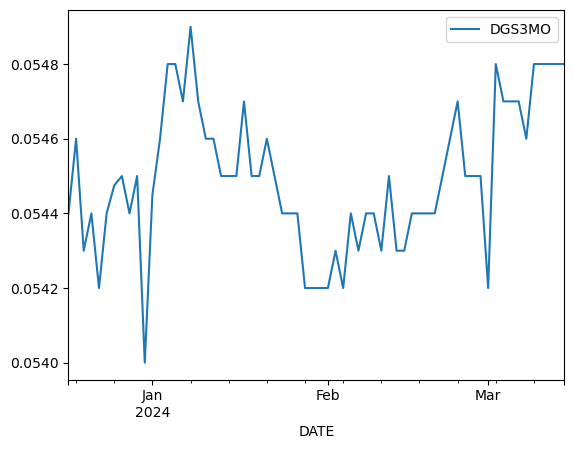

In [189]:
# calibrate using 3mon treasury bill YTM for the past 6 months
df_1_yc = pd.read_csv("DGS3MO.csv")

# data cleaning
df_1_yc.index = pd.to_datetime(df_1_yc.DATE)
df_1_yc = df_1_yc.dropna().drop(columns=["DATE"])
df_1_yc.DGS3MO = df_1_yc.DGS3MO.replace(".", np.nan).astype(float)/100
df_1_yc = df_1_yc.dropna()

# filter out calibration period
df_1_yc = df_1_yc['2023-12-15':'2024-03-15']

df_1_yc.plot()

In [190]:
initial_model_params = {
    "kappa": 0.5,
    "mu_r": 0.03,
    "sigma": 0.03,
    "mu": 0,
    "gamma": 0.01,
    "r": 10,   
    "p": 0.5,   
}

bounds = [
    (0.001, 3),  # kappa - tightened upper bound
    (0.001, 0.05),  # mu_r - tightened upper bound
    (0.001, 0.2),  # sigma - tightened upper bound
    (0.01, 0.99),  # p
    (0.001, 0.05),  # mu
    (1, 50),  # r - reduced upper bound
    (0.001, 0.5)  # gamma - reduced upper bound
]


calibrator = Calibration(
    data=df_1_yc['DGS3MO'],  # Use the cleaned 'DGS3MO' column for calibration
    dt=1/252,
    model_class=ECIRModel,
    initial_params=initial_model_params,
    params=["kappa", "mu_r", "sigma", "mu", "gamma", "r", "p"]  # List of parameter names
)

result = calibrator.calibrate(bounds=bounds)

differential_evolution step 1: f(x)= -269.48641903510105
differential_evolution step 2: f(x)= -341.18266697912173
differential_evolution step 3: f(x)= -352.359006859129
differential_evolution step 4: f(x)= -361.0198150688327
differential_evolution step 5: f(x)= -388.90050316833623
differential_evolution step 6: f(x)= -388.90050316833623
Invalid transition_prob encountered: 0.0 for params [7.45617699e-01 1.59788961e-02 1.14828087e-03 6.04369524e-01
 4.71733757e-03 2.44750603e+01 3.20382738e-01]
differential_evolution step 7: f(x)= -420.1373444717981
differential_evolution step 8: f(x)= -420.1373444717981
differential_evolution step 9: f(x)= -420.1373444717981
differential_evolution step 10: f(x)= -423.24298690287924
differential_evolution step 11: f(x)= -423.24298690287924
differential_evolution step 12: f(x)= -423.24298690287924
differential_evolution step 13: f(x)= -423.24298690287924
differential_evolution step 14: f(x)= -423.24298690287924
differential_evolution step 15: f(x)= -423.

In [191]:
result

             message: Optimization terminated successfully.
             success: True
                 fun: -432.73874758410597
                   x: [ 2.846e-02  4.589e-02  8.951e-03  1.000e-02
                        9.861e-03  1.213e+00  5.000e-01]
                 nit: 26
                nfev: 3019
          population: [[ 1.791e-01  1.237e-02 ...  1.213e+00  4.986e-01]
                       [ 1.497e-01  4.124e-02 ...  1.173e+00  4.796e-01]
                       ...
                       [ 2.950e-02  1.483e-02 ...  1.008e+00  4.712e-01]
                       [ 1.689e-01  4.716e-02 ...  1.155e+00  4.913e-01]]
 population_energies: [-4.327e+02 -4.257e+02 ... -4.214e+02 -4.271e+02]
                 jac: [-5.369e-02 -2.233e-01 -1.643e-01  2.960e+02
                       -8.160e-02  0.000e+00 -1.242e+02]

params = {
    "kappa": 0.02846,
    "mu_r": 0.04589,
    "sigma": 0.008951,
    "mu": 0.009861,
    "gamma": 0.500,
    "r": 1.213,  # Rounded to nearest integer if required by your model
    "p": 0.01
}